# Projekt AAI
s20154 Damian Kijańczuk

# Predykcja ceny komórek

W tym projekcie zajmiemy się predykcją ceny komórek na podstawie ich danych technicznych. Dane są pobrane z serwisu [Kaggle](https://www.kaggle.com/datasets/pratikgarai/mobile-phone-specifications-and-prices). Dane są w repozytorium, by samemu je ściągnąć nalezy odkomentować ponizsze linijki.

In [1]:
#!pip install kaggle
#import kaggle.json token by hand
#!mkdir ~/.kaggle/
#!mv /content/kaggle.json ~/.kaggle/


In [2]:
#import kaggle
#kaggle.api.dataset_download_files(
#    'pratikgarai/mobile-phone-specifications-and-prices',
#    unzip=True)

# 1. Przygotowanie danych

Po pobraniu danych z serwisu wczytamy dane do zmiennej oraz pozbędziemy się zbędnych kolumn z nazwą modelu oraz ID.

In [3]:
import pandas as pd

data = pd.read_csv('ndtv_data_final.csv', delimiter=',')
DATA = data.drop(columns=["Unnamed: 0", "Name", "Model"])
DATA.head()

,Brand,Battery capacity (mAh),Screen size (inches),Touchscreen,Resolution x,Resolution y,Processor,RAM (MB),Internal storage (GB),Rear camera,Front camera,Operating system,Wi-Fi,Bluetooth,GPS,Number of SIMs,3G,4G/ LTE,Price
0,OnePlus,4085,6.67,Yes,1440,3120,8,12000,256.0,48.0,16.0,Android,Yes,Yes,Yes,2,Yes,Yes,58998
1,Realme,4000,6.50,Yes,1080,2400,8,6000,64.0,64.0,16.0,Android,Yes,Yes,Yes,2,Yes,Yes,27999
2,Apple,3969,6.50,Yes,1242,2688,6,4000,64.0,12.0,12.0,iOS,Yes,Yes,Yes,2,Yes,Yes,106900
3,Apple,3110,6.10,Yes,828,1792,6,4000,64.0,12.0,12.0,iOS,Yes,Yes,Yes,2,Yes,Yes,62900
4,LG,4000,6.40,Yes,1080,2340,8,6000,128.0,12.0,32.0,Android,Yes,Yes,Yes,1,No,No,49990


Zanim będziemy korzystać z tych danych musimy jeszcze je odpowienio spreparować. Dane w kolumnach 'Brand' i 'Operating system' będzie trzeba zamienić z ciągów znaków na wartości numeryczne. Każda unikalna wartość otrzyma swój numer.

In [4]:
text_cols = ['Brand', 'Operating system']
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
for col in text_cols:
    DATA[col] = label_encoder.fit_transform(DATA[col].astype(str))

Będziemy także musieli zmienić ciągi znaków "Yes" i "No", na wartości 1 i 0.

In [5]:
bool_cols = ['Touchscreen', 'Wi-Fi', 'Bluetooth', 'GPS', '3G', '4G/ LTE']
for col in bool_cols:
    DATA[col] = DATA[col].map({"Yes": 1, "No": 0})

Poniżej przedstawione są dane po potrzebnych zmiannach:

In [6]:
DATA.head()

,Brand,Battery capacity (mAh),Screen size (inches),Touchscreen,Resolution x,Resolution y,Processor,RAM (MB),Internal storage (GB),Rear camera,Front camera,Operating system,Wi-Fi,Bluetooth,GPS,Number of SIMs,3G,4G/ LTE,Price
0,44,4085,6.67,1,1440,3120,8,12000,256.0,48.0,16.0,0,1,1,1,2,1,1,58998
1,53,4000,6.50,1,1080,2400,8,6000,64.0,64.0,16.0,0,1,1,1,2,1,1,27999
2,3,3969,6.50,1,1242,2688,6,4000,64.0,12.0,12.0,6,1,1,1,2,1,1,106900
3,3,3110,6.10,1,828,1792,6,4000,64.0,12.0,12.0,6,1,1,1,2,1,1,62900
4,29,4000,6.40,1,1080,2340,8,6000,128.0,12.0,32.0,0,1,1,1,1,0,0,49990


Na koniec musimy podzielić dane na zbiory do trenowania i testowania

In [7]:
from sklearn.model_selection import train_test_split

X = DATA.drop('Price', axis=1)
y = DATA['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Proste modele

Zaczniemy od predykcji korzystając z pięciu prostych modeli z biblioteki 'sklearn'. Będą to:

- Drzewa decyzyjne
- K najbliższych sąsiadów
- Naiwny klasyfikator bayesowski
- Las losowy
- Gradient boosting

In [8]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Initialize the models
decision_tree_model = DecisionTreeRegressor()
knn_model = KNeighborsRegressor()
naive_bayes_model = GaussianNB()
random_forest_model = RandomForestRegressor()
gradient_boosting_model = GradientBoostingRegressor()

# Train the models
decision_tree_model.fit(X_train, y_train)
knn_model.fit(X_train, y_train)
naive_bayes_model.fit(X_train, y_train)
random_forest_model.fit(X_train, y_train)
gradient_boosting_model.fit(X_train, y_train)

# Make predictions
decision_tree_predictions = decision_tree_model.predict(X_test)
knn_predictions = knn_model.predict(X_test)
naive_bayes_predictions = naive_bayes_model.predict(X_test)
random_forest_predictions = random_forest_model.predict(X_test)
gradient_boosting_predictions = gradient_boosting_model.predict(X_test)

Po uczeniu modelów czas je ocenić, użyjemy do tego błędu średniokwadratowego (RMSE) oraz współczynnika determinacji (R^2):

In [9]:
# Calculate RMSE for each model
decision_tree_rmse = mean_squared_error(y_test, decision_tree_predictions, squared=False)
knn_rmse = mean_squared_error(y_test, knn_predictions, squared=False)
naive_bayes_rmse = mean_squared_error(y_test, naive_bayes_predictions, squared=False)
random_forest_rmse = mean_squared_error(y_test, random_forest_predictions, squared=False)
gradient_boosting_rmse = mean_squared_error(y_test, gradient_boosting_predictions, squared=False)

# Calculate R-squared for each model
decision_tree_r2 = r2_score(y_test, decision_tree_predictions)
knn_r2 = r2_score(y_test, knn_predictions)
naive_bayes_r2 = r2_score(y_test, naive_bayes_predictions)
random_forest_r2 = r2_score(y_test, random_forest_predictions)
gradient_boosting_r2 = r2_score(y_test, gradient_boosting_predictions)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


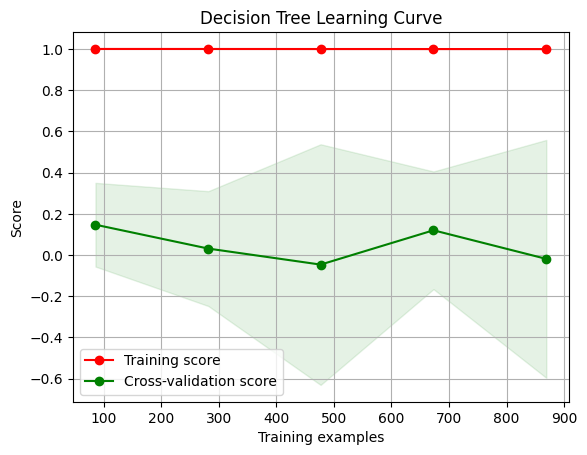

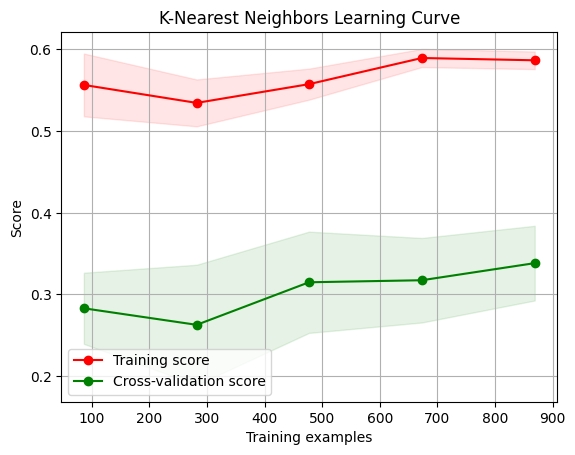

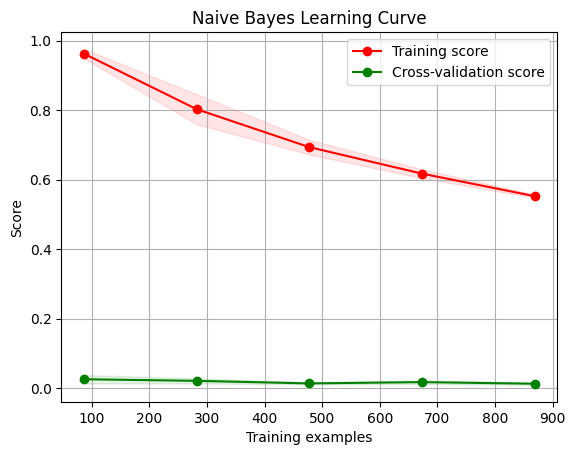

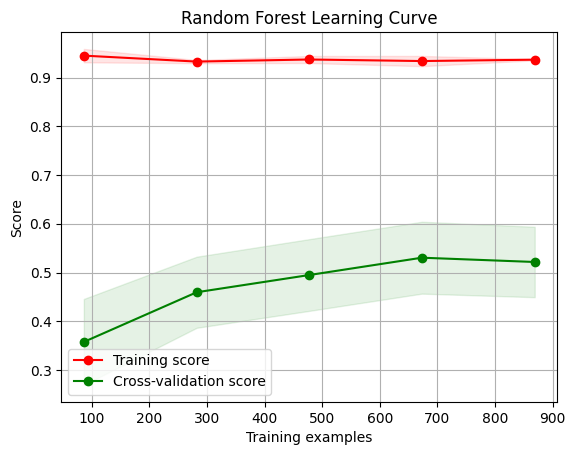

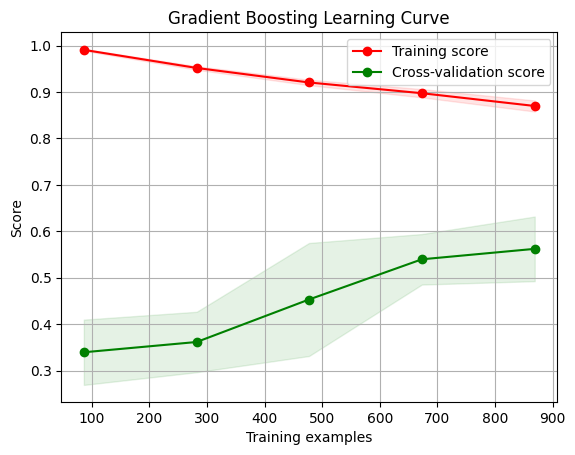

In [11]:
import numpy as np
from sklearn.model_selection import learning_curve, cross_val_score

# Learning curves
def plot_learning_curve(estimator, title, X, y, cv, train_sizes=np.linspace(.1, 1.0, 5)):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    return plt

# Metrics and cross-validation
def evaluate_model(estimator, X, y, cv):
    # Calculate metrics
    predictions = estimator.predict(X)
    rmse = mean_squared_error(y, predictions, squared=False)
    r2 = r2_score(y, predictions)

    # Perform cross-validation
    scores = cross_val_score(estimator, X, y, cv=cv, scoring='neg_mean_squared_error')
    cv_rmse = np.sqrt(-scores)
    cv_r2 = cross_val_score(estimator, X, y, cv=cv, scoring='r2')

    return rmse, r2, cv_rmse, cv_r2

# Define the models
models = {
    'Decision Tree': decision_tree_model,
    'K-Nearest Neighbors': knn_model,
    'Naive Bayes': naive_bayes_model,
    'Random Forest': random_forest_model,
    'Gradient Boosting': gradient_boosting_model
}

# Initialize lists to store results
learning_curve_plots = []
metrics = {}
cross_val_results = {}

# Evaluate each model
for name, model in models.items():
    # Learning curves
    plot = plot_learning_curve(model, f"{name} Learning Curve", X_train, y_train, cv=5)
    learning_curve_plots.append(plot)

    # Metrics and cross-validation
    rmse, r2, cv_rmse, cv_r2 = evaluate_model(model, X_test, y_test, cv=5)
    metrics[name] = {'RMSE': rmse, 'R-squared': r2}
    cross_val_results[name] = {'RMSE': cv_rmse, 'R-squared': cv_r2}

# Show learning curves
for plot in learning_curve_plots:
    plot.show()


In [12]:
# Print metrics and cross-validation results
for name, metric_values in metrics.items():
    print(f"{name}:")
    print(f"  RMSE: {metric_values['RMSE']}")
    print(f"  R-squared: {metric_values['R-squared']}\n")

for name, cv_results in cross_val_results.items():
    print(f"{name} Cross-Validation:")
    print(f"  RMSE: {np.mean(cv_results['RMSE'])} (+/- {np.std(cv_results['RMSE'])})")
    print(f"  R-squared: {np.mean(cv_results['R-squared'])} (+/- {np.std(cv_results['R-squared'])})\n")

Decision Tree:
  RMSE: 11705.9896014312
  R-squared: 0.4801394751051944

K-Nearest Neighbors:
  RMSE: 11501.259905638983
  R-squared: 0.49816446731034036

Naive Bayes:
  RMSE: 12850.980141865353
  R-squared: 0.37346825887778834

Random Forest:
  RMSE: 9313.649562570798
  R-squared: 0.6709132784982622

Gradient Boosting:
  RMSE: 9594.477733848362
  R-squared: 0.6507686268224104

Decision Tree Cross-Validation:
  RMSE: 11951.138021974413 (+/- 4663.408760233281)
  R-squared: -0.02611878588523746 (+/- 0.8988734216849495)

K-Nearest Neighbors Cross-Validation:
  RMSE: 11853.89391522688 (+/- 4925.797169631719)
  R-squared: 0.276769915266699 (+/- 0.2067750618011011)

Naive Bayes Cross-Validation:
  RMSE: 12998.23197589786 (+/- 7444.62301872397)
  R-squared: 0.10626639770612303 (+/- 0.2178608365082816)

Random Forest Cross-Validation:
  RMSE: 9984.054360730583 (+/- 5242.073685345682)
  R-squared: 0.5057589793766637 (+/- 0.1013977091119237)

Gradient Boosting Cross-Validation:
  RMSE: 9852.4795

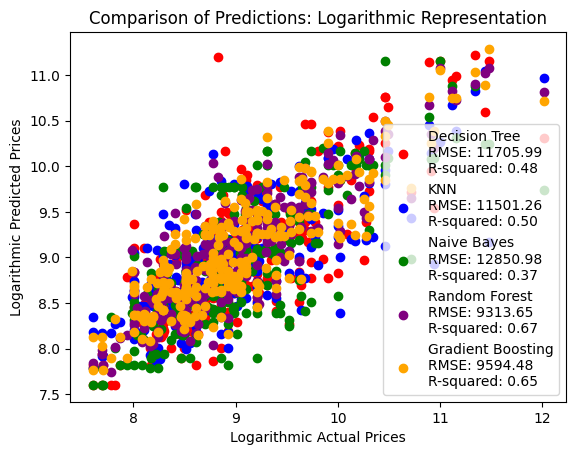

In [13]:
import numpy as np

# Apply logarithmic transformation to the actual prices and predicted prices
y_test_log = np.log1p(y_test)
decision_tree_predictions_log = np.log1p(decision_tree_predictions)
knn_predictions_log = np.log1p(knn_predictions)
naive_bayes_predictions_log = np.log1p(naive_bayes_predictions)
random_forest_predictions_log = np.log1p(random_forest_predictions)
gradient_boosting_predictions_log = np.log1p(gradient_boosting_predictions)

# Plotting the logarithmic predictions
plt.scatter(y_test_log, decision_tree_predictions_log, color='red', label=f"Decision Tree\nRMSE: {decision_tree_rmse:.2f}\nR-squared: {decision_tree_r2:.2f}")
plt.scatter(y_test_log, knn_predictions_log, color='blue', label=f"KNN\nRMSE: {knn_rmse:.2f}\nR-squared: {knn_r2:.2f}")
plt.scatter(y_test_log, naive_bayes_predictions_log, color='green', label=f"Naive Bayes\nRMSE: {naive_bayes_rmse:.2f}\nR-squared: {naive_bayes_r2:.2f}")
plt.scatter(y_test_log, random_forest_predictions_log, color='purple', label=f"Random Forest\nRMSE: {random_forest_rmse:.2f}\nR-squared: {random_forest_r2:.2f}")
plt.scatter(y_test_log, gradient_boosting_predictions_log, color='orange', label=f"Gradient Boosting\nRMSE: {gradient_boosting_rmse:.2f}\nR-squared: {gradient_boosting_r2:.2f}")

# Plot settings
plt.xlabel('Logarithmic Actual Prices')
plt.ylabel('Logarithmic Predicted Prices')
plt.title('Comparison of Predictions: Logarithmic Representation')
plt.legend()
plt.show()

Widzimy że najlepszym modelem jest 'Random Forest' z dokładnością 67% a zaraz za nim 'Gradient Boosting' z 66%. Zobaczmy jeszcze porównianie najgorszego i najlepszego modelu.

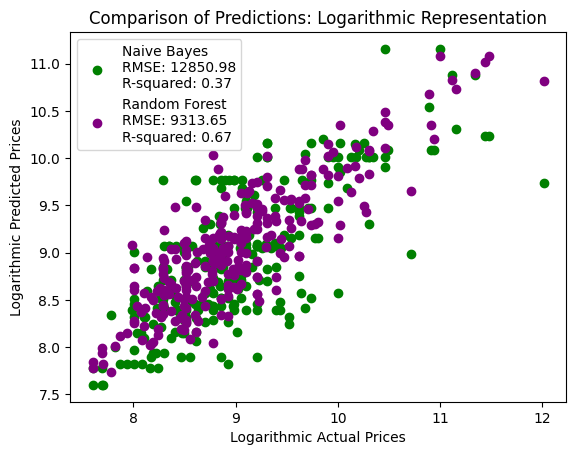

In [14]:
# Plotting the logarithmic predictions
plt.scatter(y_test_log, naive_bayes_predictions_log, color='green', label=f"Naive Bayes\nRMSE: {naive_bayes_rmse:.2f}\nR-squared: {naive_bayes_r2:.2f}")
plt.scatter(y_test_log, random_forest_predictions_log, color='purple', label=f"Random Forest\nRMSE: {random_forest_rmse:.2f}\nR-squared: {random_forest_r2:.2f}")

# Plot settings
plt.xlabel('Logarithmic Actual Prices')
plt.ylabel('Logarithmic Predicted Prices')
plt.title('Comparison of Predictions: Logarithmic Representation')
plt.legend()
plt.show()

# 3. Zaawansowany model

Po napisaniu i sprawdzeniu prostych modeli, czas napisać kolejny przy użyciu PyTorch. Zaczniemy jednak od przygotowania danych.

In [15]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Separate the categorical features
categorical_features = X[['Brand', 'Operating system']]

# One-hot encode the categorical features
encoder = OneHotEncoder(sparse=False)
categorical_features_encoded = encoder.fit_transform(categorical_features)

# Normalize the numerical features
numerical_features = X.drop(['Brand', 'Operating system'], axis=1).values
scaler = StandardScaler()
numerical_features_scaled = scaler.fit_transform(numerical_features)

# Concatenate the encoded categorical features and the scaled numerical features
X_scaled = np.concatenate((numerical_features_scaled, categorical_features_encoded), axis=1)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Następnie czas stworzyć model. Będziemy korzystać z 3 warstw full connected.
Po każdej warstwie używana jest funkcja aktywacji ReLU.

Wybraliśmy 3 warstwy ponieważ są one wstanie nauczyć się nieliniowych zależności pomiędzy cechami i ekstrahować istotne cech w procesie predykcji.
Taka architektura jest prosta i uniwersalna. Pozwala ona rozwiązywać wiele problemów, a poniewąż nie mamy bardzo dużej ilości danych oraz cech, uczenie wykonuje się szybko i daje dobre efekty.

Używamy funkcji aktywacji ReLU (Rectified Linear Unit) po każdej warstwie ponieważ,  pomaga on w rozpraszaniu gradientów podczas propagacji wstecznej co przyspiesza to proces uczenia się. Dzięki niemu także unikamy zjawiska zanikającego gradientu, który występuje w niektórych innych funkcjach aktywacji, takich jak sigmoida. Dzięki temu, informacje o gradientach mogą swobodnie przepływać wstecz przy backpropagation. Jest to także najczęściej używana funkcja aktywacji na zajęciach więc zakładam iż jest ona najlepsza :)

Do obliczania jak bardzo predykcje różnią się od oczekiwanych wartości kożystamy z MSE - Mean Squared Error. Wybraliśmy go ponieważ chcemy przewidzieć cenę komórki która jest wartością liczbową.

Jako optymalizator (odpowiedzialny za aktualizację wag modelu w celu minimalizacji funkcji straty) wybraliśmy ADAM z powodu jego popularności. Jest on często wykorzystywany i dobrze sprawdzał się wielu innych modelach. Learning rate będzie wynosił 0.001, gdyż pomoże osiągnąć bardziej stabline wagi, a wzrost w czasie uczenia dla danych takich rozmiarów, znacznie się nie zwiększy.

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Convert X_scaled and y to PyTorch tensors
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.float32)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

# Define the neural network model
class MobilePricePredictionModel(nn.Module):
    def __init__(self, input_size):
        super(MobilePricePredictionModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

# Instantiate the model
input_size = X_train.shape[1]
model = MobilePricePredictionModel(input_size)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Create the dataloaders
batch_size = 32
train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

Po definicji modelu czas go uruchomić i nauczyć. Model będzie się uczyć przez 1000 epok.

In [17]:
# Initialize variables to store RMSE and R-squared values
nn_rmse = []
nn_r2 = []
num_epochs = 1000
train_losses = []
test_losses = []

model.train()
for epoch in range(num_epochs):
    running_loss = 0.0

    for batch_features, batch_targets in train_dataloader:
        optimizer.zero_grad()
        outputs = model(batch_features)
        loss = criterion(outputs, batch_targets.unsqueeze(1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * batch_features.size(0)

    epoch_loss = running_loss / len(train_dataset)
    train_losses.append(epoch_loss)

    model.eval()
    with torch.no_grad():
        y_pred_train = model(X_train)
        train_loss = criterion(y_pred_train, y_train.unsqueeze(1))

        y_pred_test = model(X_test)
        test_loss = criterion(y_pred_test, y_test.unsqueeze(1))
        predictions = y_pred_test.squeeze().tolist()

        nn_rmse.append(mean_squared_error(y_test, predictions, squared=False))
        nn_r2.append(r2_score(y_test, predictions))

        test_losses.append(test_loss.item())

        print(f"Epoch {epoch+1} - Training Loss: {train_loss.item()}, Testing Loss: {test_loss.item()}")
        print(f"Epoch {epoch+1} - RMSE: {nn_rmse[-1]}, R-squared: {nn_r2[-1]}")

Epoch 1 - Training Loss: 302488992.0, Testing Loss: 406600864.0
Epoch 1 - RMSE: 20164.346599059296, R-squared: -0.5425486458368891
Epoch 2 - Training Loss: 302346624.0, Testing Loss: 406445792.0
Epoch 2 - RMSE: 20160.499873114404, R-squared: -0.5419601620117311
Epoch 3 - Training Loss: 301845376.0, Testing Loss: 405901632.0
Epoch 3 - RMSE: 20147.00162932197, R-squared: -0.5398960478772161
Epoch 4 - Training Loss: 300685376.0, Testing Loss: 404640640.0
Epoch 4 - RMSE: 20115.681566750238, R-squared: -0.5351119958263453
Epoch 5 - Training Loss: 298505760.0, Testing Loss: 402275008.0
Epoch 5 - RMSE: 20056.79602326432, R-squared: -0.5261375453331576
Epoch 6 - Training Loss: 294892320.0, Testing Loss: 398335744.0
Epoch 6 - RMSE: 19958.35069522441, R-squared: -0.5111927460936019
Epoch 7 - Training Loss: 289472256.0, Testing Loss: 392411552.0
Epoch 7 - RMSE: 19809.379069476447, R-squared: -0.48871747610286875
Epoch 8 - Training Loss: 282327744.0, Testing Loss: 384572160.0
Epoch 8 - RMSE: 19610

Wyświetlmy 'train_losses' i 'test_losses' na wykresie.

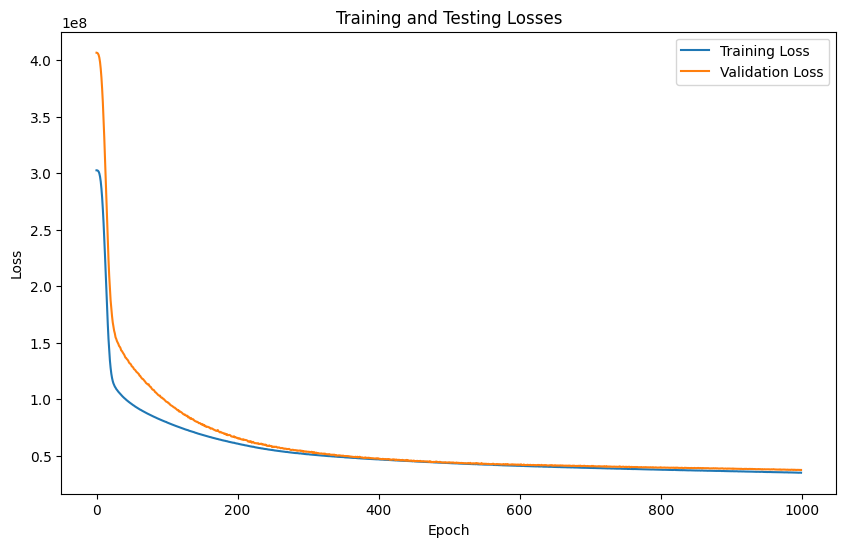

In [18]:
# Plot the training and testing losses
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Losses')
plt.legend()
plt.show()

Na początku uczenia Validation Loss jest nad Training Loss co wskazuje na overfitting, lecz obie wartości szybko spadają by połączyć się około 300 epoki. Wskazuje to że model jest dobrze wytrenowany i nie występuje overfitting i underfitting.

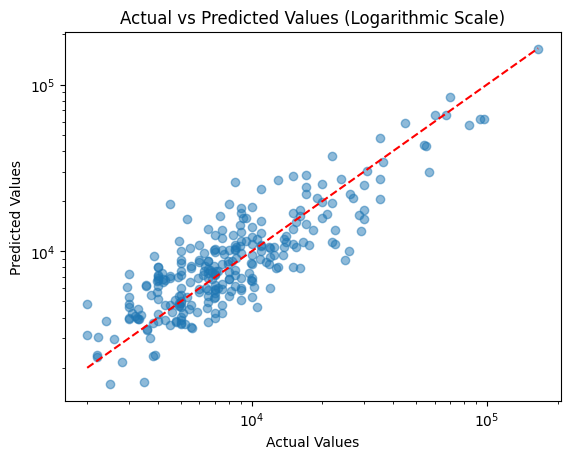

In [19]:
# Plot the predicted values and actual values with logarithmic scale
plt.scatter(y_test, predictions, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values (Logarithmic Scale)')
plt.xscale('log')
plt.yscale('log')
plt.show()

# 3. Porównanie modeli

By porównać modele wyświetlimy ich dokładność na wykresie.

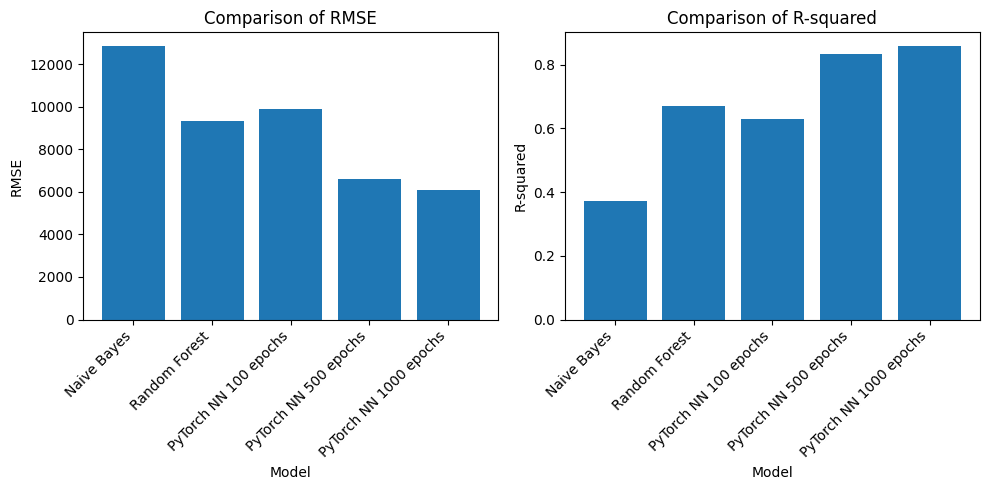

In [20]:
import matplotlib.pyplot as plt

# Create lists of RMSE and R-squared values
rmse_values = [naive_bayes_rmse, random_forest_rmse, nn_rmse[99], nn_rmse[499], nn_rmse[999]]
r2_values = [naive_bayes_r2, random_forest_r2, nn_r2[99], nn_r2[499], nn_r2[999]]

# Define the models' names for plotting
model_names = ['Naive Bayes', 'Random Forest', 'PyTorch NN 100 epochs', 'PyTorch NN 500 epochs', 'PyTorch NN 1000 epochs']

# Plotting RMSE values
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(model_names, rmse_values)
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.title('Comparison of RMSE')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels by 45 degrees

# Plotting R-squared values
plt.subplot(1, 2, 2)
plt.bar(model_names, r2_values)
plt.xlabel('Model')
plt.ylabel('R-squared')
plt.title('Comparison of R-squared')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels by 45 degrees

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

Z wykresu widać iż model stworzony w PyTorch jest najdokładniejszy z wszystkich użytych. Już przy 100 epokach model zbliża się do Random Forest a przy 500 wyprzedza go o około 16 punktów procentowych. Przy 1000 jest jeszcze lepszy lecz tępo wzrostu dokładności spada.

# Ocenianie win

Teraz postaramy się przewidzieć ocenę wina za pomocą tych samych modeli co poprzednio.

# 1. Przygotowanie danych

In [62]:
wines = pd.read_csv('winequalityN.csv', delimiter=',')
wines.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [63]:
wines = wines.fillna(0)
wines.isnull().sum()

type                    0
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

Tak jak w przypadku komórek trzeba zamienić ciąg znaków na wartość liczbową.

In [64]:
text_cols = ['type']
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
for col in text_cols:
    wines[col] = label_encoder.fit_transform(wines[col].astype(str))

wines.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,1,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,1,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,1,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,1,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


Musimy także podzielić dane na zbiory.

In [65]:
X = wines.drop('quality', axis=1)
y = wines['quality']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Proste modele



In [66]:
# Initialize the models
decision_tree_model = DecisionTreeRegressor()
knn_model = KNeighborsRegressor()
naive_bayes_model = GaussianNB()
random_forest_model = RandomForestRegressor()
gradient_boosting_model = GradientBoostingRegressor()

# Train the models
decision_tree_model.fit(X_train, y_train)
knn_model.fit(X_train, y_train)
naive_bayes_model.fit(X_train, y_train)
random_forest_model.fit(X_train, y_train)
gradient_boosting_model.fit(X_train, y_train)

# Make predictions
decision_tree_predictions = decision_tree_model.predict(X_test)
knn_predictions = knn_model.predict(X_test)
naive_bayes_predictions = naive_bayes_model.predict(X_test)
random_forest_predictions = random_forest_model.predict(X_test)
gradient_boosting_predictions = gradient_boosting_model.predict(X_test)

In [67]:
# Calculate RMSE for each model
decision_tree_rmse = mean_squared_error(y_test, decision_tree_predictions, squared=False)
knn_rmse = mean_squared_error(y_test, knn_predictions, squared=False)
naive_bayes_rmse = mean_squared_error(y_test, naive_bayes_predictions, squared=False)
random_forest_rmse = mean_squared_error(y_test, random_forest_predictions, squared=False)
gradient_boosting_rmse = mean_squared_error(y_test, gradient_boosting_predictions, squared=False)

# Calculate R-squared for each model
decision_tree_r2 = r2_score(y_test, decision_tree_predictions)
knn_r2 = r2_score(y_test, knn_predictions)
naive_bayes_r2 = r2_score(y_test, naive_bayes_predictions)
random_forest_r2 = r2_score(y_test, random_forest_predictions)
gradient_boosting_r2 = r2_score(y_test, gradient_boosting_predictions)

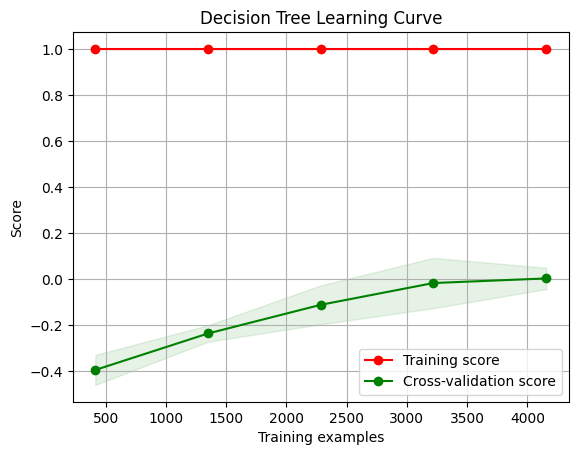

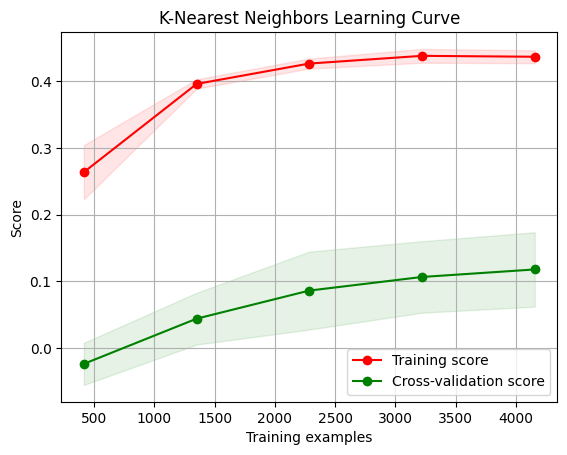

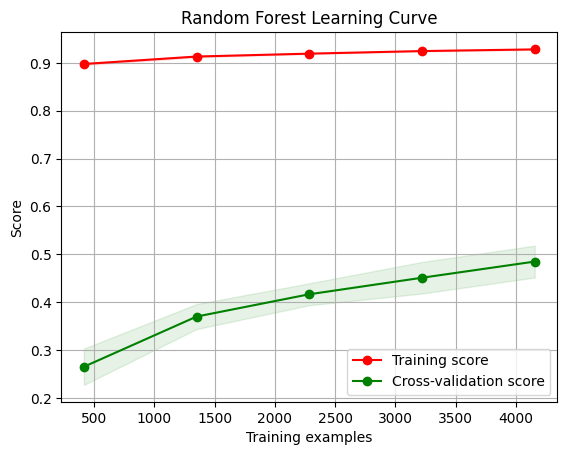

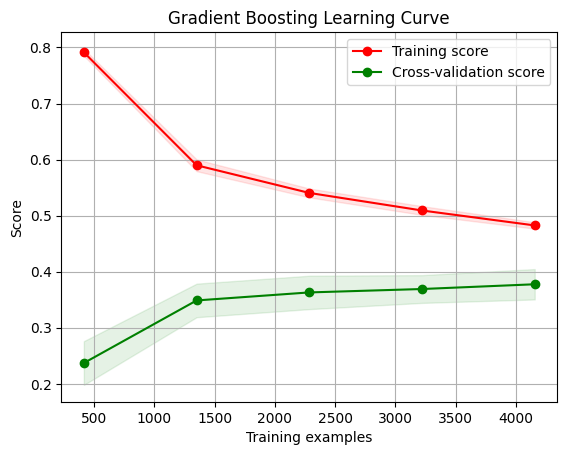

In [83]:
import numpy as np
from sklearn.model_selection import learning_curve, cross_val_score

# Learning curves
def plot_learning_curve(estimator, title, X, y, cv, train_sizes=np.linspace(.1, 1.0, 5)):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    return plt

# Metrics and cross-validation
def evaluate_model(estimator, X, y, cv):
    # Calculate metrics
    predictions = estimator.predict(X)
    rmse = mean_squared_error(y, predictions, squared=False)
    r2 = r2_score(y, predictions)

    # Perform cross-validation
    scores = cross_val_score(estimator, X, y, cv=cv, scoring='neg_mean_squared_error')
    cv_rmse = np.sqrt(-scores)
    cv_r2 = cross_val_score(estimator, X, y, cv=cv, scoring='r2')

    return rmse, r2, cv_rmse, cv_r2

# Define the models
models = {
    'Decision Tree': decision_tree_model,
    'K-Nearest Neighbors': knn_model,
    'Random Forest': random_forest_model,
    'Gradient Boosting': gradient_boosting_model
}

# Initialize lists to store results
learning_curve_plots = []
metrics = {}
cross_val_results = {}

# Evaluate each model
for name, model in models.items():
    # Learning curves
    plot = plot_learning_curve(model, f"{name} Learning Curve", X_train, y_train, cv=5)
    learning_curve_plots.append(plot)

    # Metrics and cross-validation
    rmse, r2, cv_rmse, cv_r2 = evaluate_model(model, X_test, y_test, cv=5)
    metrics[name] = {'RMSE': rmse, 'R-squared': r2}
    cross_val_results[name] = {'RMSE': cv_rmse, 'R-squared': cv_r2}

# Show learning curves
for plot in learning_curve_plots:
    plot.show()

In [84]:
# Print metrics and cross-validation results
for name, metric_values in metrics.items():
    print(f"{name}:")
    print(f"  RMSE: {metric_values['RMSE']}")
    print(f"  R-squared: {metric_values['R-squared']}\n")

for name, cv_results in cross_val_results.items():
    print(f"{name} Cross-Validation:")
    print(f"  RMSE: {np.mean(cv_results['RMSE'])} (+/- {np.std(cv_results['RMSE'])})")
    print(f"  R-squared: {np.mean(cv_results['R-squared'])} (+/- {np.std(cv_results['R-squared'])})\n")

Decision Tree:
  RMSE: 0.7760848486523186
  R-squared: 0.15737522257661563

K-Nearest Neighbors:
  RMSE: 0.7874594006628581
  R-squared: 0.13249465443609365

Random Forest:
  RMSE: 0.5584099679515869
  R-squared: 0.5637633597707306

Gradient Boosting:
  RMSE: 0.6404739912382691
  R-squared: 0.4261230091985697

Decision Tree Cross-Validation:
  RMSE: 0.9217334321859759 (+/- 0.04411282726285253)
  R-squared: -0.1742390077809015 (+/- 0.10444011088253681)

K-Nearest Neighbors Cross-Validation:
  RMSE: 0.8314230419475408 (+/- 0.02930532787352442)
  R-squared: 0.029970857854852873 (+/- 0.023658837493364122)

Random Forest Cross-Validation:
  RMSE: 0.6649716871411008 (+/- 0.029272616383725223)
  R-squared: 0.3806919331046699 (+/- 0.04029329030383343)

Gradient Boosting Cross-Validation:
  RMSE: 0.6726992576660115 (+/- 0.022209600172256885)
  R-squared: 0.3640009303431374 (+/- 0.0320058965596717)



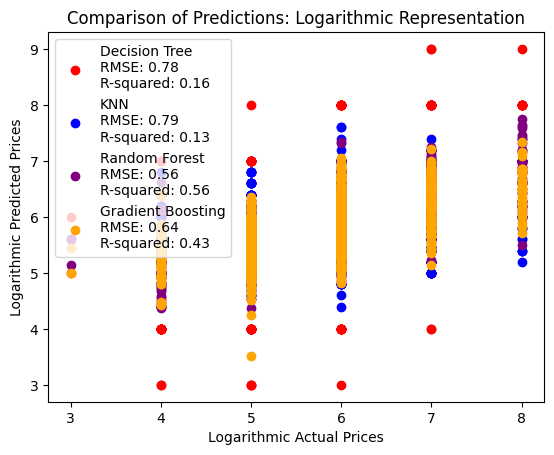

In [85]:
import numpy as np

# Plotting the logarithmic predictions
plt.scatter(y_test, decision_tree_predictions, color='red', label=f"Decision Tree\nRMSE: {decision_tree_rmse:.2f}\nR-squared: {decision_tree_r2:.2f}")
plt.scatter(y_test, knn_predictions, color='blue', label=f"KNN\nRMSE: {knn_rmse:.2f}\nR-squared: {knn_r2:.2f}")
plt.scatter(y_test, random_forest_predictions, color='purple', label=f"Random Forest\nRMSE: {random_forest_rmse:.2f}\nR-squared: {random_forest_r2:.2f}")
plt.scatter(y_test, gradient_boosting_predictions, color='orange', label=f"Gradient Boosting\nRMSE: {gradient_boosting_rmse:.2f}\nR-squared: {gradient_boosting_r2:.2f}")

# Plot settings
plt.xlabel('Logarithmic Actual Prices')
plt.ylabel('Logarithmic Predicted Prices')
plt.title('Comparison of Predictions: Logarithmic Representation')
plt.legend()
plt.show()

Tak jak w poprzednim przypadku 'Random Forest' jest najlepszym z prostych modeli.

# 3. Zaawansowany model

In [87]:
# Normalize the numerical features
numerical_features = X.values
scaler = StandardScaler()
numerical_features_scaled = scaler.fit_transform(numerical_features)

# Concatenate the encoded categorical features and the scaled numerical features
X_scaled = numerical_features_scaled

Przy danych z winem użyjemy tego samego modelu

In [88]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Convert X_scaled and y to PyTorch tensors
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.float32)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

# Define the neural network model
class MobilePricePredictionModel(nn.Module):
    def __init__(self, input_size):
        super(MobilePricePredictionModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

# Instantiate the model
input_size = X_train.shape[1]
model = MobilePricePredictionModel(input_size)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Create the dataloaders
batch_size = 32
train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [89]:
# Initialize variables to store RMSE and R-squared values
nn_rmse = []
nn_r2 = []
num_epochs = 1000
train_losses = []
test_losses = []

model.train()
for epoch in range(num_epochs):
    running_loss = 0.0

    for batch_features, batch_targets in train_dataloader:
        optimizer.zero_grad()
        outputs = model(batch_features)
        loss = criterion(outputs, batch_targets.unsqueeze(1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * batch_features.size(0)

    epoch_loss = running_loss / len(train_dataset)
    train_losses.append(epoch_loss)

    model.eval()
    with torch.no_grad():
        y_pred_train = model(X_train)
        train_loss = criterion(y_pred_train, y_train.unsqueeze(1))

        y_pred_test = model(X_test)
        test_loss = criterion(y_pred_test, y_test.unsqueeze(1))
        predictions = y_pred_test.squeeze().tolist()

        nn_rmse.append(mean_squared_error(y_test, predictions, squared=False))
        nn_r2.append(r2_score(y_test, predictions))

        test_losses.append(test_loss.item())

        print(f"Epoch {epoch+1} - Training Loss: {train_loss.item()}, Testing Loss: {test_loss.item()}")
        print(f"Epoch {epoch+1} - RMSE: {nn_rmse[-1]}, R-squared: {nn_r2[-1]}")

Epoch 1 - Training Loss: 1.642877459526062, Testing Loss: 1.3668850660324097
Epoch 1 - RMSE: 1.1691385845252684, R-squared: -0.9122638009193329
Epoch 2 - Training Loss: 1.0683902502059937, Testing Loss: 0.9325861930847168
Epoch 2 - RMSE: 0.9657049616198794, R-squared: -0.30468221505818804
Epoch 3 - Training Loss: 0.8186948895454407, Testing Loss: 0.713138997554779
Epoch 3 - RMSE: 0.8444755438514522, R-squared: 0.0023229765542320813
Epoch 4 - Training Loss: 0.6578351259231567, Testing Loss: 0.5782946944236755
Epoch 4 - RMSE: 0.7604569219635259, R-squared: 0.1909692076350853
Epoch 5 - Training Loss: 0.5920329093933105, Testing Loss: 0.5256101489067078
Epoch 5 - RMSE: 0.7249897422255744, R-squared: 0.2646746463306897
Epoch 6 - Training Loss: 0.5532680153846741, Testing Loss: 0.4921177327632904
Epoch 6 - RMSE: 0.7015110535807241, R-squared: 0.31153026447377363
Epoch 7 - Training Loss: 0.5356357097625732, Testing Loss: 0.47332414984703064
Epoch 7 - RMSE: 0.6879856008795239, R-squared: 0.337

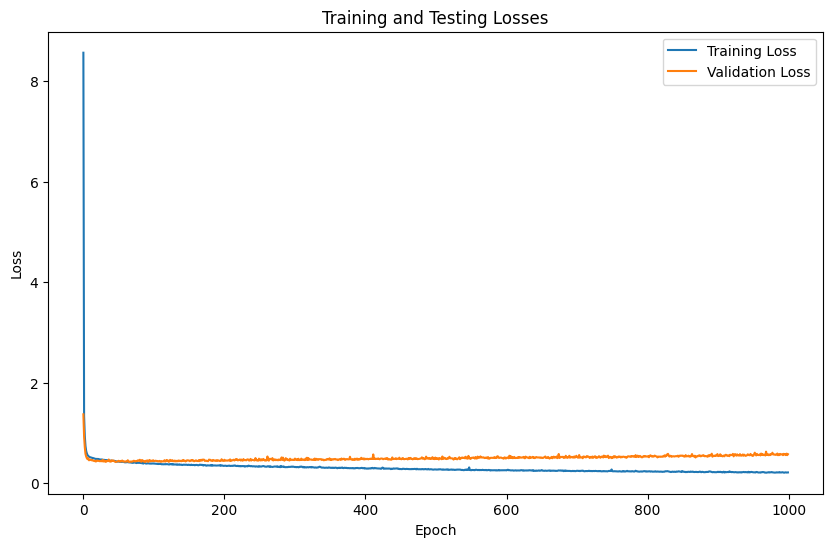

In [90]:
# Plot the training and testing losses
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Losses')
plt.legend()
plt.show()

Widzimy że model bardzo szybko się uczy i przy 1000 epokach ma on overfitting. Wyświetlmy więc wykres dal mniejszej ilości epok.

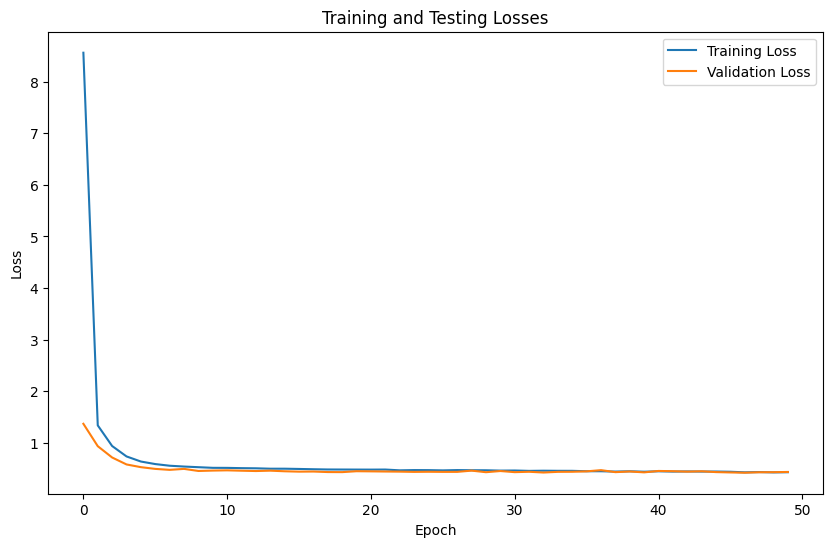

In [93]:
# Plot the training and testing losses
plt.figure(figsize=(10, 6))
plt.plot(train_losses[:50], label='Training Loss')
plt.plot(test_losses[:50], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Losses')
plt.legend()
plt.show()

Jak widzimy model ten bardzo szybko nauczył się rozpoznawania jakości win.

# 3. Porównanie modeli

By porównać modele wyświetlimy ich dokładność na wykresie.

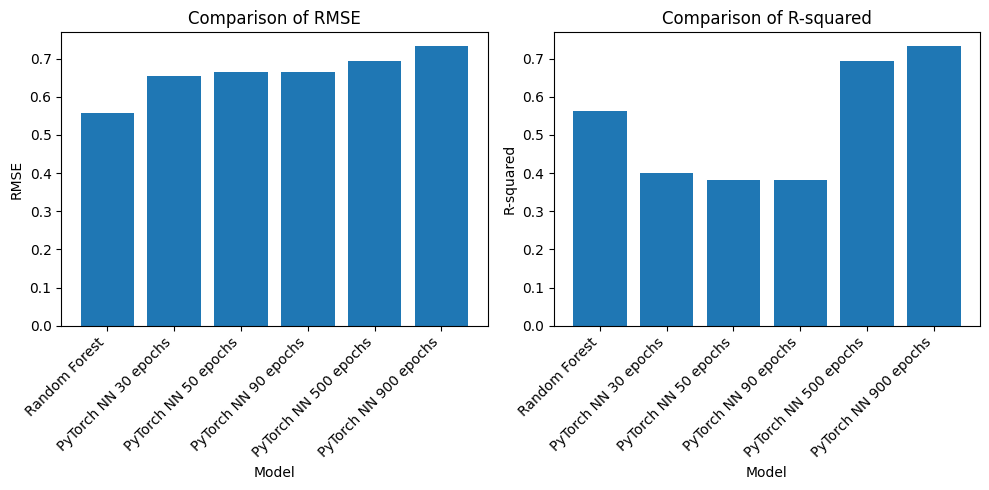

In [96]:
# Create lists of RMSE and R-squared values
rmse_values = [random_forest_rmse, nn_rmse[30], nn_rmse[50], nn_rmse[90],nn_rmse[500], nn_rmse[900]]
r2_values = [random_forest_r2, nn_r2[30], nn_r2[50], nn_r2[90],nn_rmse[500], nn_rmse[900]]

# Define the models' names for plotting
model_names = ['Random Forest', 'PyTorch NN 30 epochs', 'PyTorch NN 50 epochs', 'PyTorch NN 90 epochs','PyTorch NN 500 epochs', 'PyTorch NN 900 epochs']

# Plotting RMSE values
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(model_names, rmse_values)
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.title('Comparison of RMSE')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels by 45 degrees

# Plotting R-squared values
plt.subplot(1, 2, 2)
plt.bar(model_names, r2_values)
plt.xlabel('Model')
plt.ylabel('R-squared')
plt.title('Comparison of R-squared')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels by 45 degrees

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

Jak widzimy model napisany w PyTorch jest lepszy od 'Random Forest'. Warto zauważyć, że po jakimś czasie uczenia model robi się coraz gorszy i występuje przetrenowanie.